# [[데이콘] 영화 리뷰 감성 분석](https://dacon.io/competitions/official/235995/overview/description)

**참고 사이트**  
[[기업은행] 영화 리뷰 감성 분석 PBL 1](https://dacon.io/competitions/official/235995/codeshare/6528?page=1&dtype=recent)

## 1. 데이터 살펴보기
### 1) 데이터 불러오기

In [1]:
# 데이터를 불러오고 살펴보기 위한 라이브러리
import pandas as pd
import numpy as np

# 시각화를 하기 위한 라이브러리
import matplotlib.pyplot as plt
%matplotlib inline

import sys
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer

In [12]:
train = pd.read_csv('data/[기업은행 혁신리그 사전강의] 영화 리뷰 감성 분석/train.csv')
test = pd.read_csv('data/[기업은행 혁신리그 사전강의] 영화 리뷰 감성 분석/test.csv')
submission = pd.read_csv('data/[기업은행 혁신리그 사전강의] 영화 리뷰 감성 분석/sample_submission.csv')

In [13]:
print(len(train))
print(len(test))

150000
50000


In [14]:
print(train.head())
print('\n')
print(train.tail())

   id                                           document  label
0   1                                아 더빙.. 진짜 짜증나네요 목소리      0
1   2                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2   3                                  너무재밓었다그래서보는것을추천한다      0
3   4                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   5  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1


            id                         document  label
149995  149996              인간이 문제지.. 소는 뭔죄인가..      0
149996  149997                    평점이 너무 낮아서...      1
149997  149998  이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?      0
149998  149999      청춘 영화의 최고봉.방황과 우울했던 날들의 자화상      1
149999  150000         한국 영화 최초로 수간하는 내용이 담긴 영화      0


### 2) 데이터 정제하기
#### (1) 중복 행 제거

In [15]:
# 중복 행 찾기
train[train['document'].duplicated()] # 총 3,817행 존재

,id,document,label
1058,1059,4,0
1097,1098,쵝오,1
1248,1249,최고,1
1483,1484,최고,1
1707,1708,재밌다,1
...,...,...,...
149919,149920,짱,1
149949,149950,OO 영화,0
149960,149961,지루하다,0
149966,149967,1,0


In [16]:
# 중복 행 제거
train.drop_duplicates(['document'], inplace=True)
len(train)

146183

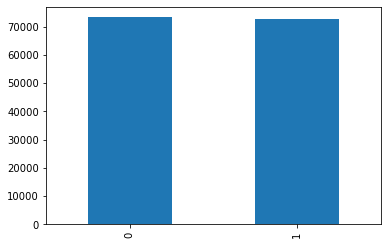

In [23]:
# 중복을 제거한 train.label 분포
train.label.value_counts().plot(kind='bar');

In [24]:
train.label.value_counts() # 0(부정) > 1(긍정)

0    73342
1    72841
Name: label, dtype: int64

#### (2) 결측치 찾기

In [28]:
print('결측치 개수: {}개'.format(train['document'].isnull().sum()))

결측치 개수: 1개


In [31]:
train[train['document'].isnull()]

,id,document,label
25857,25858,NaN,1


In [35]:
# 결측치 제거
train = train.dropna(how='any')  # how = 'any' : row 또는 column에 NaN값이 1개만 있어도 drop
train.isnull().values.any()

False

In [36]:
# 결측치 제거 후, 라벨 분포
train.label.value_counts() # 0(부정) > 1(긍정)

0    73342
1    72840
Name: label, dtype: int64

### 3) validation 셋을 활용한 검증

In [38]:
from sklearn.model_selection import train_test_split

X = train[['document']]
y = train[['label']]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.5, random_state=24)

In [39]:
print(f"X_train.shape : {X_train.shape}")
print(f"y_train.shape : {y_train.shape}")
print(f"X_valid.shape : {X_valid.shape}")
print(f"y_valid.shape : {y_valid.shape}")

X_train.shape : (73091, 1)
y_train.shape : (73091, 1)
X_valid.shape : (73091, 1)
y_valid.shape : (73091, 1)


In [42]:
# label을 모두 1로 가정하여 y_valid와 비교하여 정확도 평가
pred = y_valid.copy() # y_valid 값을 복사
pred[['label']] = 1 # label 값을 모두 1로 변환

from sklearn.metrics import accuracy_score
print(accuracy_score(y_valid, pred))

0.4998152987371906


## 2. 텍스트 전처리